In [1]:
import sys
sys.path.append("../scripts/")
from rrtstar import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
import matplotlib.patches as patches
import math
import random
import copy

In [4]:
def rotation_matrix(t):
    return np.array([[np.cos(t), -np.sin(t)], [np.sin(t),  np.cos(t)]])

class InformedRRTstar(RRTstar):
    def __init__(self, grid_map_world, ratioPointGoal=0.9, R=3):
        super(InformedRRTstar, self).__init__(grid_map_world, ratioPointGoal, R)
        self.marker_size = 6
        self.R = R
        self.epsilon =0.1 * np.linalg.norm(self.world.grid_step)
        self.a = float('inf')
        self.b = float('inf')
        self.c_best = float('inf')
        self.c_min = np.linalg.norm(self.start_cordinate - self.goal_cordinate)
        self.e_theta = np.arctan2(self.goal_cordinate[1]-self.start_cordinate[1], self.goal_cordinate[0]-self.start_cordinate[0])
    
    def draw(self, ax, elems):
        xs, xn, xp = self.InformedRRTstar()
        
        if(self.drawReconnectAreaflag):
            self.drawReconnectArea(ax, elems, xn)
        self.drawEdge(ax, elems)    #全エッジを描画
        if(self.drawVertexflag):
            self.drawVertex(ax, elems)    #全頂点を描画
        self.drawPath(ax, elems)    #得られた経路の描画
        if(xs is None or xn is None or xp is None):
            return
        self.drawSamplingPoint(ax, elems, xs)    #サンプリング点を描画
        if(self.isFinish):
            self.drawEllipse(ax, elems)
          
    def InformedRRTstar(self):
        if(self.isStart):
            x, y = self.start_cordinate
            self.vertex = np.vstack([self.vertex, [x, y, 0.0]])
            self.parent.append(0)
            self.isStart = False
            self.id = np.vstack([self.id, [x, y]])
        
        xn, yn = None, None
        xp, yp = None, None
        xp_n, yp_n = None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        
        while(isFindVertex == False):    #結べる点が得られるまで繰り返す
            #サンプリング
            if(self.isFinish):
                if(np.isnan(self.a) or np.isnan(self.b)):
                    return None, None, None
                theta = 2*random.random()*np.pi - np.pi
                x = np.sqrt(random.random()) * np.array([np.cos(theta)*self.a, np.sin(theta)*self.b])
                xp = np.dot(rotation_matrix(self.e_theta), x) + (self.start_cordinate + self.goal_cordinate) / 2
            else:
                if(random.random() > self.ratePointGoal and not(self.isFinish)):
                    xp = self.goal_cordinate   #ある確率でゴールを選択する
                else:
                    r1 = random.random()
                    r2 = random.random()
                    xp = self.world.grid_num * self.world.grid_step * np.array([r1, r2])
                    xp = self.returnGoalGrid(xp)
            if(self.isPoseInObstacle(xp)):
                continue
            candidate = self.vertex
            while(1):
                xn, xp_n, cost_n, nearest_id = self.getNearestVertex(xp, candidate)    #[xp, yp]に最も近い頂点を探索
                if(self.isPoseInGoal(xn)):
                    xn= self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #隣接ノードと半径1.1 grid_step以内であれば除外する
                #障害物に当たったりマップ外に出たりした場合はxn=xp_n, yn=yp_n
                if(np.linalg.norm(xn - xp_n) < 0.001 * np.linalg.norm(self.world.grid_step)):
                    candidate = np.delete(candidate, nearest_id, 0)
                    if(len(candidate) == 0):
                        break
                else:
                    isFindVertex = True
                    break
        cost_new = cost_n + np.linalg.norm(xn - xp_n)
        self.vertex = np.vstack([self.vertex, [xn[0], xn[1], cost_new]])
        self.edge.append([xn[0], xn[1], xp_n[0], xp_n[1]])
        self.parent.append(xp_n)
        self.id = np.vstack([self.id, [xn[0], xn[1]]])
        
        #エッジの変更
        for vertex in self.getNeigborVertex(xn):
            neigbor = vertex[0:2]
            c = vertex[2]
            if(c > cost_new + np.linalg.norm(xn - neigbor)):
                isCollision, _ = self.collisionFree(np.array(neigbor), np.array(xn), type2=False)
                if(isCollision == 0 or isCollision == 2):
                    continue
                parent = self.parent[self.get_id(neigbor)]
                self.edge.remove([neigbor[0], neigbor[1], parent[0], parent[1]])
                self.edge.append([neigbor[0], neigbor[1], xn[0], xn[1]])
                self.parent[self.get_id(neigbor)] = xn
                self.changeChildCost(neigbor)
        return xp, xn, xp_n    #サンプリング点，新しい点，ペアレント点を返す
    
    def drawEllipse(self, ax, elems):
        e = patches.Ellipse(
            xy=(self.start_cordinate+self.goal_cordinate)/2,
            width=self.a*2,
            height=self.b*2,
            angle=np.rad2deg(self.e_theta),
            ec='black',
            fill=False
        )
        elems.append(ax.add_patch(e))  
            
    def drawPath(self, ax, elems):
        if(self.isFinish): #ゴールからスタート
            id = self.get_id(self.goal_cordinate)
            distance = 0
            while(id != 0):    #スタート（id=0）になるまで繰り返す
                x1 = self.id[id]
                x2 = self.parent[id]
                id = self.get_id(x2)
                elems += ax.plot([x1[0], x2[0]], [x1[1], x2[1]], color="red")
                distance += np.linalg.norm(x1 - x2)
            self.c_best = distance
            self.a = self.c_best/2
            self.b = np.sqrt(distance**2 - self.c_min**2)/2
            
            dis_str ="Distance = %.4f" % (distance)
            elems.append(
                ax.text(
                    self.world.grid_step[0]*self.world.grid_num[0]*0.6,
                    self.world.grid_step[1]*self.world.grid_num[1]*1.02,
                    dis_str,
                    fontsize=10
                )
            )

<IPython.core.display.Javascript object>


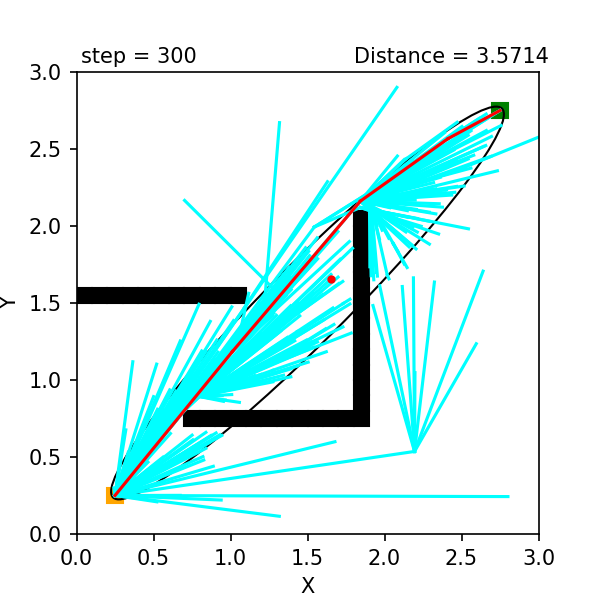

In [6]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map4.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(InformedRRTstar(world, R=5, ratioPointGoal=0.0))
    
    world.draw()
    #world.ani.save('input.gif', writer='pillow', fps=100)    #アニメーション保存